In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import zscore

In [2]:
# Load the dataset 
df = pd.read_csv("TelcoCustomerChurn.csv")

In [3]:
# Rename dataset for consistency
df.rename(columns=lambda x: x.strip(), inplace=True)

In [4]:
# Drop customer ID (not useful for model)
df.drop(columns=["customerID"], inplace=True)

In [5]:
# Convert categorical target variable to numerical
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

In [6]:
# Handling missing values separately for numerical and categorical columns
for col in df.columns:
    if df[col].dtype == 'object':  # Categorical column
        df[col].fillna(df[col].mode()[0], inplace=True)  # Fill with most frequent value
    else:  # Numerical column
        df[col].fillna(df[col].median(), inplace=True)  # Fill with median

C:\Users\sandh\AppData\Local\Temp\ipykernel_9708\682245988.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)  # Fill with most frequent value
C:\Users\sandh\AppData\Local\Temp\ipykernel_9708\682245988.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [7]:
# Convert categorical variables into numerical using Label Encoding & One-Hot Encoding
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

In [8]:
# Normalize numerical features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled["Churn"] = df["Churn"] 

In [9]:
# Splitting features and target variable
X = df_scaled.drop(columns=["Churn"])
y = df_scaled["Churn"]

In [10]:
# Outlier Detection & Removal using Z-Score
z_scores = np.abs(zscore(X))
outlier_mask = (z_scores < 3).all(axis=1)  # Identify non-outliers
X = X[outlier_mask]
y = y[outlier_mask]

In [11]:
# 2. Feature Selection Techniques

# a) Chi-Square Test for feature selection (for categorical data)
chi2_selector = SelectKBest(score_func=chi2, k=10)

In [12]:
# Important: Chi-Square requires positive values, so use unscaled categorical data if applicable
X_chi2_selected = chi2_selector.fit_transform(df.drop(columns=["Churn"]), df["Churn"])
selected_chi2_features = df.drop(columns=["Churn"]).columns[chi2_selector.get_support()]

print("Selected Features using Chi-Square Test:", selected_chi2_features.tolist())

Selected Features using Chi-Square Test: ['SeniorCitizen', 'Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract', 'MonthlyCharges', 'TotalCharges']


gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


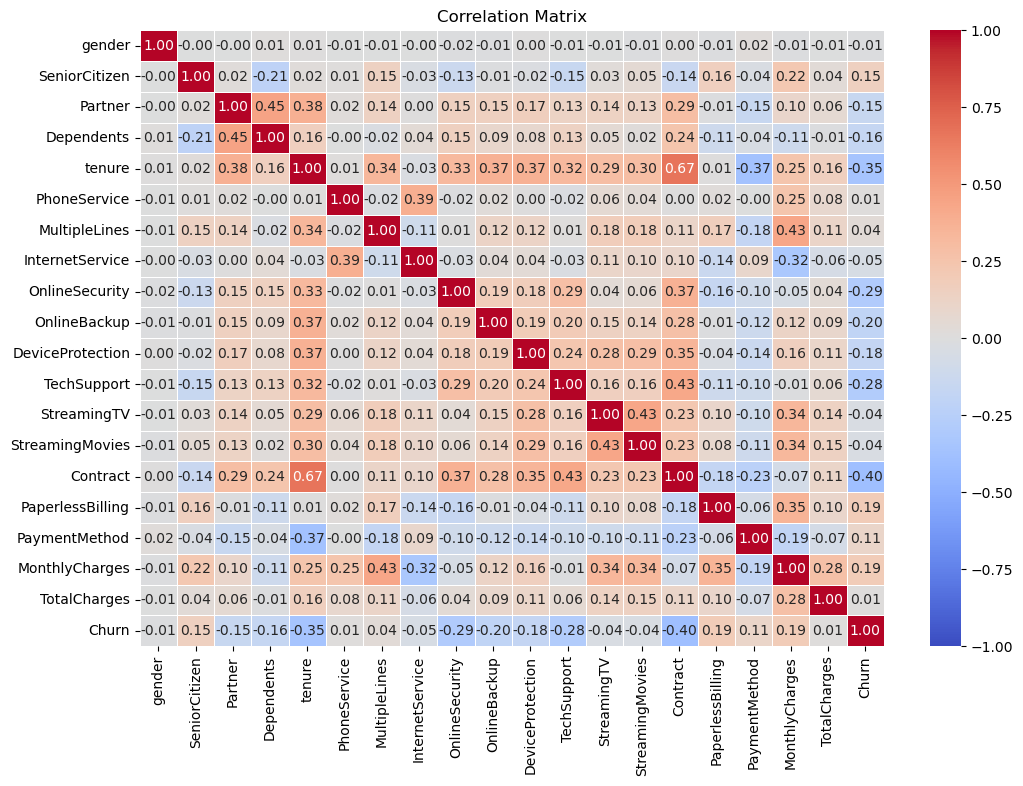

In [13]:
# b) Correlation Matrix to check multicollinearity
df_encoded = pd.get_dummies(df, drop_first=True)  # One-hot encoding
correlation_matrix = df_encoded.corr()

print(df.isnull().sum())  # Check for missing values
df.fillna(df.median(), inplace=True)  # Fill missing values with median

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [14]:
# c) Lasso Regression for Feature Selection
lasso = LassoCV(cv=5, random_state=42).fit(X, y)
lasso_selected_features = X.columns[lasso.coef_ != 0]
print("Selected Features using Lasso Regularization:", lasso_selected_features.tolist())

Selected Features using Lasso Regularization: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


In [15]:
# d) Recursive Feature Elimination (RFE) with Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf, n_features_to_select=10)
rfe.fit(X, y)
rfe_selected_features = X.columns[rfe.support_]
print("Selected Features using RFE:", rfe_selected_features.tolist())

Selected Features using RFE: ['gender', 'tenure', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'Contract', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


In [16]:
# 3. Feature Extraction using PCA & ICA

# a) PCA (Principal Component Analysis)
pca = PCA(n_components=10)  # Retain 10 principal components
X_pca = pca.fit_transform(X)
print("Explained Variance Ratio (PCA):", pca.explained_variance_ratio_)

Explained Variance Ratio (PCA): [0.19886227 0.13294493 0.07261256 0.06495358 0.05894611 0.05585334
 0.04944771 0.04674687 0.04533441 0.04441501]


In [17]:
# b) ICA (Independent Component Analysis)
ica = FastICA(n_components=10, random_state=42)
X_ica = ica.fit_transform(X)
print("ICA Transformation Completed")

ICA Transformation Completed


In [18]:
# Final Dataset Preparation
# Choose the best feature selection method and transform the dataset
X_selected = X[rfe_selected_features]  # Using RFE selected features

In [19]:
# Final dataset
print(f"Final dataset shape after feature engineering: {X_selected.shape}")

Final dataset shape after feature engineering: (6361, 10)


In [20]:
# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
print(f"Training Set: {X_train.shape}, Testing Set: {X_test.shape}")

Training Set: (5088, 10), Testing Set: (1273, 10)
